In [88]:
import numpy as np
import sklearn 
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas.plotting
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten


In [2]:
data_raw = pd.read_csv('sales_history.csv', sep = ';')
data_raw.head()

,date,article_name
0,2018-05-18 14:56:26,Brezel
1,2018-05-18 15:03:15,Buttercroissant
2,2018-05-18 15:28:01,Buttercroissant
3,2018-05-18 16:04:45,Buttercroissant
4,2018-05-18 16:29:56,Brezel


In [3]:
pd.unique(data_raw['article_name'])

array(['Brezel', 'Buttercroissant', 'Apfeltasche'], dtype=object)

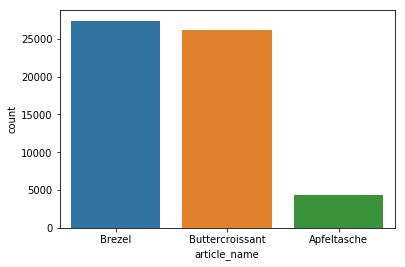

In [4]:
sns.countplot(data_raw.article_name)

In [5]:
data_raw['purchase_date'] = pd.to_datetime(data_raw['date']).dt.date
data_raw['purchase_date'] = pd.to_datetime(data_raw['purchase_date'], format='%Y/%m/%d')
data_raw.head()

,date,article_name,purchase_date
0,2018-05-18 14:56:26,Brezel,2018-05-18
1,2018-05-18 15:03:15,Buttercroissant,2018-05-18
2,2018-05-18 15:28:01,Buttercroissant,2018-05-18
3,2018-05-18 16:04:45,Buttercroissant,2018-05-18
4,2018-05-18 16:29:56,Brezel,2018-05-18


In [6]:
data = pd.DataFrame(data_raw.groupby(pd.Grouper(key='purchase_date', freq='D'))['article_name'].value_counts().unstack())
data = data.fillna(0).astype(int)
data = data.reset_index()
data.columns = ['date', 'Apfeltasche', 'Brezel', 'Buttercroissant']
data.head()

,date,Apfeltasche,Brezel,Buttercroissant
0,2018-05-18,0,25,15
1,2018-05-19,0,111,71
2,2018-05-20,0,104,87
3,2018-05-21,0,59,84
4,2018-05-22,0,46,95


In [7]:
def plot_items(df, y):
    x = df['date']
    plt.plot(x, y)
    plt.show()

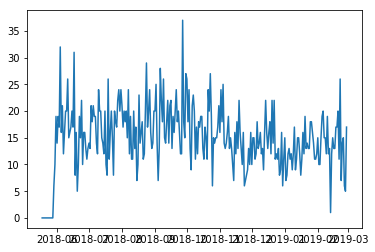

In [8]:
plot_items(data, data['Apfeltasche'])

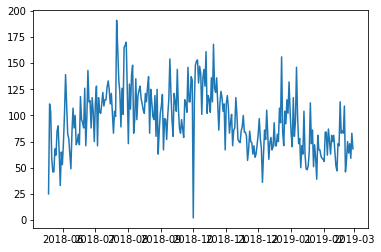

In [9]:
plot_items(data, data['Brezel'])

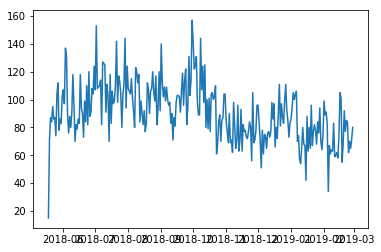

In [10]:
plot_items(data, data['Buttercroissant'])

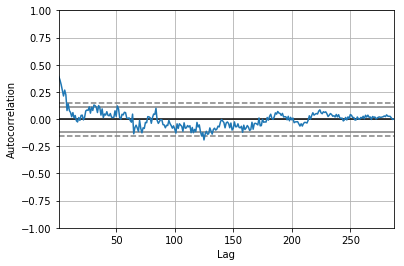

In [11]:
autocorrelation_plot(data['Apfeltasche'])
plt.show()

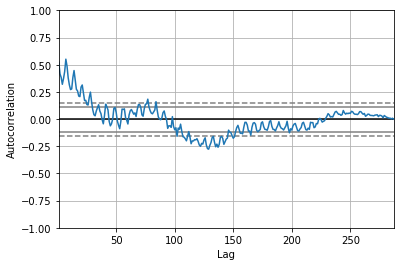

In [12]:
autocorrelation_plot(data['Brezel'])
plt.show()

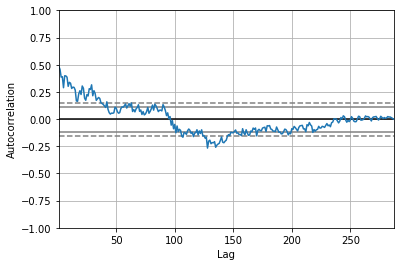

In [13]:
autocorrelation_plot(data['Buttercroissant'])
plt.show()

In [14]:
def adf_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [15]:
adf_test(data['Apfeltasche'])

ADF Statistic: -5.172735
p-value: 0.000010
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [16]:
adf_test(data['Brezel'])

ADF Statistic: -1.818447
p-value: 0.371342
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [17]:
adf_test(data['Buttercroissant'])

ADF Statistic: -2.381644
p-value: 0.146984
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [105]:
print (data['Buttercroissant'].mean())
print (data['Brezel'].mean())
print (data['Apfeltasche'].mean())

91.03484320557492
95.39372822299651
15.041811846689896


In [18]:
# I took this function from the ML mastery blog:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/


def get_labels(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [73]:
def prepare_train_test(data):
    values = data.values[:, 1:].astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = get_labels(scaled, 1, 1)
    values = reframed.values
    # 70% for the training, 30% for testing
    train = values[:int(len(data)*0.6), :]
    test = values[int(len(data)*0.6):, :]
    return train, test, scaler, scaled

In [20]:
def split_the_set(data, var):
    train = prepare_train_test(data)[0]
    test = prepare_train_test(data)[1]
    train_X, train_y = train[:, :3], train[:, var]
    test_X, test_y = test[:, :3], test[:, var]
    # the batch size, the number of time-steps and the number of units in one input sequence
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y

In [89]:
def model_fit(n_epoch, data, verbose, var):
    # design network
    train_X, train_y = split_the_set(data, var)[0], split_the_set(data, var)[1]
    test_X, test_y = split_the_set(data, var)[2], split_the_set(data, var)[3]
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_X, train_y, epochs=n_epoch, batch_size=80, validation_data=(test_X, test_y), verbose=verbose, shuffle=False)
    return model

In [22]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


In [97]:
def calc_rmse(model, var, scaler, X, y):
    X = X.reshape((X.shape[0], 1, 3))
    yhat = model.predict(X)
    
    X = X.reshape((X.shape[0], X.shape[2]))
    inverse_yhat = np.concatenate((yhat, X[:, 1:]), axis=1)
    inverse_yhat = scaler.inverse_transform(inverse_yhat)
    inverse_yhat = inverse_yhat[:,0]

    y = y.reshape((len(y), 1))
    inverse_y = np.concatenate((y, X[:, 1:]), axis=1)
    inverse_y = scaler.inverse_transform(inverse_y)
    inverse_y = inverse_y[:,0]
    rmse = math.sqrt(mean_squared_error(inverse_y, inverse_yhat))
    return rmse

In [65]:
def predict_next_val(model, X):
    X = X.reshape((X.shape[0], 1, 3))
    yhat = model.predict(X, verbose=0)
    return yhat[0][0]

def make_predictions(model, data, var):
    predictions = []
    test_X, test_y = split_the_set(data, var)[2], split_the_set(data, var)[3]
    yhat = predict_next_val(model, test_X)
    return yhat

def inverse_values(pred_vals, test_X, scaler):
    pred_vals = np.array(pred_vals)
    test_X = test_X.reshape(len(test_X), 3)
    pred_vals = pred_vals.reshape(1, 3)
    inv = np.concatenate((test_X, pred_vals))
    inverse_data = scaler.inverse_transform(inv)
    return inverse_data


In [98]:
for j in range(0, 3):
    model = model_fit(200, data, 0, (j-3))
    train_rmse = calc_rmse(model, (j-3), prepare_train_test(data)[2], split_the_set(data, (j-3))[0], split_the_set(data, (j-3))[1])
    test_rmse = calc_rmse(model, (j-3), prepare_train_test(data)[2], split_the_set(data, (j-3))[2], split_the_set(data, (j-3))[3])
    print ('Train RMSE for item', j+1, 'is',  '%.3f' % train_rmse)
    print ('Test RMSE for item', j+1, 'is',  '%.3f' % test_rmse)

Train RMSE for item 1 is 5.185
Test RMSE for item 1 is 4.569
Train RMSE for item 2 is 4.901
Test RMSE for item 2 is 5.086
Train RMSE for item 3 is 4.578
Test RMSE for item 3 is 4.455


In [106]:
predicted_data = []
rmse_array = []
for i in range(28):
    pred_vals = []
    for j in range(0, 3):
        model = model_fit(200, data, 0, (j-3))
        pred_vals.append(make_predictions(model, 1, data, (j-3)))
    data_updated = inverse_values(pred_vals, split_the_set(data, -3)[0], prepare_train_test(data)[2])
    predicted_data.append(data_updated[-1])
    print (i)
    rmse_array.append(calc_rmse(j-3))

KeyboardInterrupt: 

In [ ]:
data_predict = pd.read_csv('sales_prediciton.csv', sep = ';')
data_predict.head()
data_predict['date'] = pd.to_datetime(data_predict['date'], format='%Y/%m/%d')
len(data_predict)

data_predict.head()


In [ ]:
for i in range(len(predicted_data)):
    predicted_data[i] = predicted_data[i].tolist()
predicted_data = pd.DataFrame(predicted_data)
predicted_data.head()

In [ ]:
data_predict['Apfeltasche'] = predicted_data[0]
data_predict['Buttercroissant'] = predicted_data[2]
data_predict['Brezel'] = predicted_data[1]
data_predict.round()
data_predict.head()